# Experiment Comparison

In this notebook, we will compare the results of our simulator with real data from AWS Lambda.

In [1]:
# imports

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# using Modin and Dask for parallelization:
# from distributed import Client
# client = Client(n_workers=4)
# # Modin will connect to the Dask Client
# import modin.pandas as pd

In [2]:
from pacssim.ServerlessSimulator import ServerlessSimulator as Sim


def process_aws(arrival_rate, st_w, st_c, max_time=1e6):
    sim = Sim(arrival_rate=arrival_rate,
                warm_service_rate=1/st_w, 
                cold_service_rate=1/st_c,
                expiration_threshold=600, 
                max_time=max_time)
    sim.generate_trace(debug_print=False, progress=True)
    return sim.get_cold_start_prob()

In [3]:
import time

# load experiments
exp_df = pd.read_csv('exp.csv', index_col=0)

st_w_avg = exp_df['ServiceTimeWarm'].mean()
st_c_avg = exp_df['ServiceTimeCold'].mean()

def get_row_cold_prob(x):
    return process_aws(
        arrival_rate=x['ArrivalRate'],
        st_w=st_w_avg / 1000,
        st_c=st_c_avg / 1000,
    )

start_time = time.time()
sim_cold_probs = exp_df.apply(get_row_cold_prob, axis=1)
print(f"Calculation took {time.time() - start_time}")
sim_cold_probs

100%|██████████| 1000000/1000000 [00:50<00:00, 19828.26it/s]Calculation took 284.09241700172424



experiment_13    0.347081
experiment_14    0.231020
experiment_15    0.181562
experiment_16    0.133002
experiment_17    0.086618
experiment_19    0.044832
experiment_18    0.023279
experiment_12    0.022862
experiment_10    0.010132
experiment_11    0.007165
experiment_0     0.007128
experiment_5     0.003872
experiment_1     0.002877
experiment_6     0.002324
experiment_2     0.001886
experiment_7     0.001797
experiment_3     0.001579
experiment_8     0.001490
experiment_4     0.001366
experiment_9     0.001236
dtype: float64

Cold Start MAPE: 12.32%
Cold Start Standard Error (SE): 10.14%


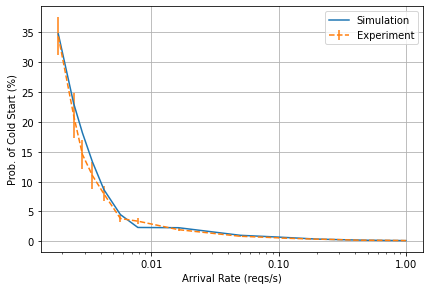

In [9]:
from matplotlib.ticker import ScalarFormatter

plt.semilogx(exp_df['ArrivalRate'], sim_cold_probs * 100, label='Simulation')
plt.errorbar(exp_df['ArrivalRate'], exp_df['ColdStartProbability']
         * 100, yerr=exp_df['ColdStartProbabilitySE'] * 100, ls='--', label='Experiment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylabel("Prob. of Cold Start (%)")
plt.xlabel('Arrival Rate (reqs/s)')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gcf().subplots_adjust(left=0.09, bottom=0.11)

mape = np.mean(np.abs((sim_cold_probs - exp_df['ColdStartProbability'])/exp_df['ColdStartProbability']*100))
print(f"Cold Start MAPE: {mape:4.2f}%")
cold_start_se = np.mean(exp_df['ColdStartProbabilitySE']/exp_df['ColdStartProbability']) * 100
print(f"Cold Start Standard Error (SE): {cold_start_se:4.2f}%")

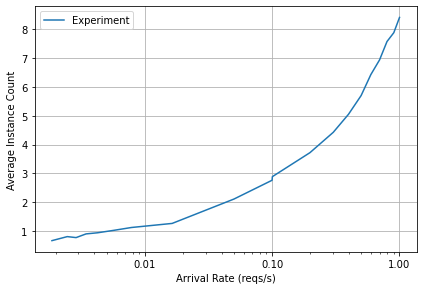

In [8]:
plt.semilogx(exp_df['ArrivalRate'], exp_df['AverageInstanceCount'], label='Experiment')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylabel("Average Instance Count")
plt.xlabel('Arrival Rate (reqs/s)')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gcf().subplots_adjust(left=0.09, bottom=0.11)